In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


 ### 讀入資料

In [45]:
ori_data = pd.read_csv('HW4_creditcard.csv')

 ### 切割資料

In [46]:
train_data,test_data,train_target,test_target = train_test_split(np.array(ori_data[ori_data.columns[:-1]]),np.array(ori_data[ori_data.columns[-1]]),test_size=0.3)

### 訓練

In [47]:
tree = DecisionTreeClassifier()
tree.fit(train_data,train_target)
tree_pred = tree.predict(test_data)

mpl = MLPClassifier()
mpl.fit(train_data, train_target)
mpl_pred = mpl.predict(test_data)


### 評分

Tree : Accuracy : 0.99,  Recall:0.75000, Precision : 0.50, F1_score : 0.60000
Tree : Accuracy : 0.99,  Recall:0.87179, Precision : 0.50, F1_score : 0.63551


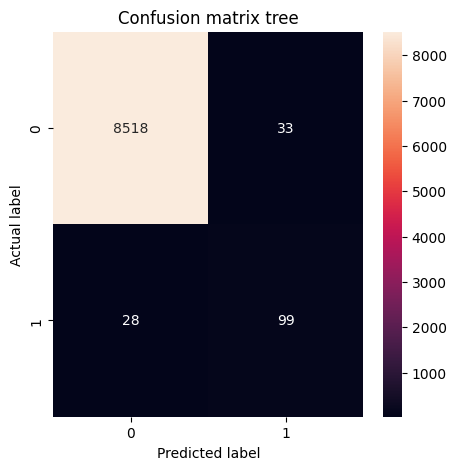

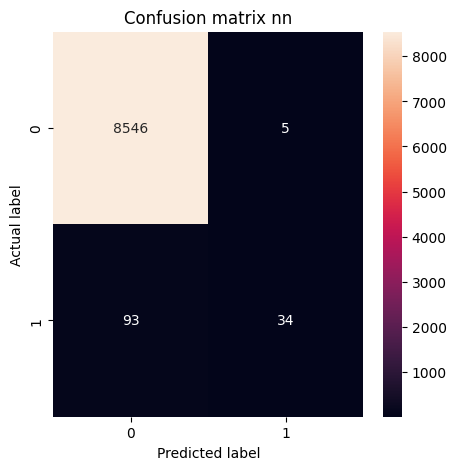

In [48]:
def score_method(target,pred,model):
    tn = len(test_target[(test_target != pred) & (test_target == 0)])
    tp = len(test_target[(test_target == pred) & (test_target == 1)])
    fn = len(test_target[(test_target != pred) & (test_target == 0)])
    fp = len(test_target[(test_target == pred) & (test_target == 1)])
    
    accuracy = (tp+fn)/(tp+fp+tn+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    F1_score = (2/(( 1/precision) + ( 1/recall)))


    cm = confusion_matrix(target, pred > 0.5)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix {model}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print(
        f'Tree : Accuracy : {score:.2f},  Recall:{recall:.5f}, Precision : {precision:.2f}, F1_score : {F1_score:.5f}')


score = tree.score(test_data, test_target)
score_method(test_target,tree_pred,'tree')



score = mpl.score(test_data, test_target)
score_method(test_target,mpl_pred,'nn')





### 統計0、1數量

0: 28432,1 : 492


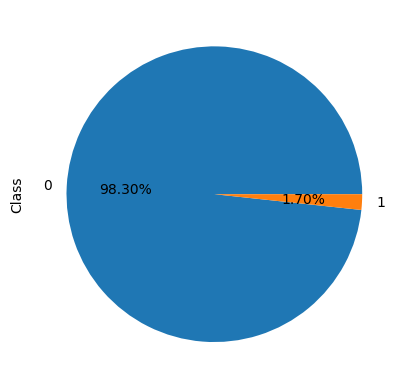

In [49]:


true_num = len(ori_data[ori_data['Class'] == 0])
false_num = len(ori_data[ori_data['Class'] == 1])

ori_data['Class'].value_counts().plot(kind='pie', autopct='%1.2f%%')
print(f'0: {true_num},1 : {false_num}')


### 改變類別權重

 - 決策樹

In [50]:
total = len(train_target)
pos = len(train_target[train_target == 1])
neg = len(train_target[train_target == 0])

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

tree = DecisionTreeClassifier(class_weight=class_weight)
tree.fit(train_data, train_target)
tree_pred = tree.predict(test_data)

score_method(test_target,tree_pred)



Weight for class 0: 0.51
Weight for class 1: 27.73


TypeError: score_method() missing 1 required positional argument: 'model'

些許提升 recall 、f1-score 值

 - 神經網絡

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
train_data =train_data
train_target =train_target

val_data = test_data[:int(len(test_data)*0.33)]
val_target = test_target[:int(len(test_data)*0.33)]

test_data_cnn = test_data[int(len(test_data)*0.33):]
test_target_cnn = test_target[int(len(test_data)*0.33):]


In [ ]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]


In [ ]:
def make_model(metrics=METRICS):
    model = keras.Sequential([
        
        keras.layers.Dense(100, activation='relu',input_shape=(train_data.shape[-1],)),
        keras.layers.Dense(1, activation='sigmoid',),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model


In [ ]:
EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [ ]:
model = make_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = make_model()
baseline_history = model.fit(
    train_data,
    train_target[:,np.newaxis],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_data, val_target))

Epoch 1/100
20/20 [==============================] - 3s 45ms/step - loss: 176.1000 - tp: 31.0000 - fp: 2039.0000 - tn: 17849.0000 - fn: 327.0000 - accuracy: 0.8831 - precision: 0.0150 - recall: 0.0866 - auc: 0.4919 - prc: 0.0170 - val_loss: 135.0425 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 2797.0000 - val_fn: 64.0000 - val_accuracy: 0.9773 - val_precision: 0.5000 - val_recall: 0.0154 - val_auc: 0.5075 - val_prc: 0.0321
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 100.8104 - tp: 0.0000e+00 - fp: 14.0000 - tn: 19874.0000 - fn: 358.0000 - accuracy: 0.9816 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4996 - prc: 0.0176 - val_loss: 127.9253 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 2797.0000 - val_fn: 64.0000 - val_accuracy: 0.9773 - val_precision: 0.5000 - val_recall: 0.0154 - val_auc: 0.5075 - val_prc: 0.0321
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 83.7295 - tp: 0.0000e+00 - fp: 14.0000 - tn: 19874.0000 - fn: 358.0

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch,
             history.history[metric], color='r', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8, 1])
    else:
      plt.ylim([0, 1])

    plt.legend()


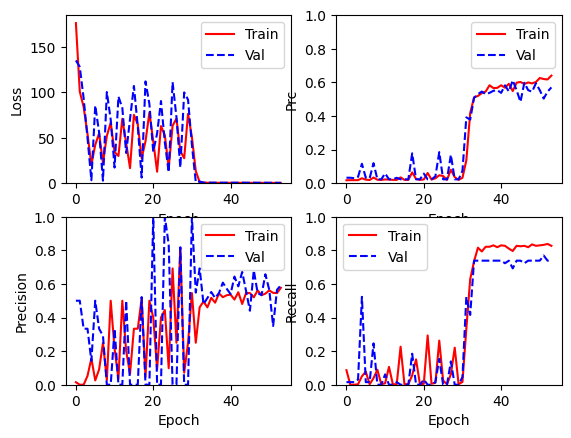

In [ ]:
plot_metrics(baseline_history)


In [ ]:
train_predictions_baseline = model.predict(
    train_data, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_data_cnn, batch_size=BATCH_SIZE)


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print(
      'Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


loss :  0.389168918132782
tp :  53.0
fp :  49.0
tn :  5697.0
fn :  16.0
accuracy :  0.9888219833374023
precision :  0.5196078419685364
recall :  0.7681159377098083
auc :  0.8803579211235046
prc :  0.49919089674949646

Legitimate Transactions Detected (True Negatives):  5697
Legitimate Transactions Incorrectly Detected (False Positives):  49
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  53
Total Fraudulent Transactions:  69


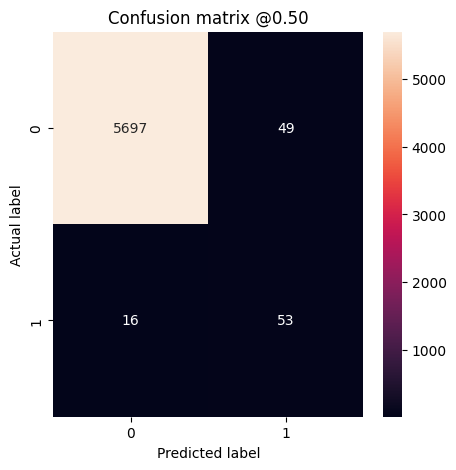

In [ ]:
baseline_results = model.evaluate(test_data_cnn, test_target_cnn[:,np.newaxis],
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_target_cnn[:, np.newaxis], test_predictions_baseline)


In [ ]:
total = len(train_target)
pos = len(train_target[train_target == 1])
neg = len(train_target[train_target == 0])

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')


Weight for class 0: 0.51
Weight for class 1: 28.28


In [ ]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_data,
    train_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_data, val_target),
    class_weight=class_weight)


Epoch 1/100
20/20 [==============================] - 2s 52ms/step - loss: 5689.2119 - tp: 411.0000 - fp: 19919.0000 - tn: 5715.0000 - fn: 16.0000 - accuracy: 0.2351 - precision: 0.0202 - recall: 0.9625 - auc: 0.5931 - prc: 0.0202 - val_loss: 2279.1787 - val_tp: 63.0000 - val_fp: 2790.0000 - val_tn: 8.0000 - val_fn: 2.0000 - val_accuracy: 0.0248 - val_precision: 0.0221 - val_recall: 0.9692 - val_auc: 0.4866 - val_prc: 0.0221
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 630.8451 - tp: 57.0000 - fp: 3748.0000 - tn: 16140.0000 - fn: 301.0000 - accuracy: 0.8000 - precision: 0.0150 - recall: 0.1592 - auc: 0.4847 - prc: 0.0166 - val_loss: 655.5421 - val_tp: 63.0000 - val_fp: 2768.0000 - val_tn: 30.0000 - val_fn: 2.0000 - val_accuracy: 0.0325 - val_precision: 0.0223 - val_recall: 0.9692 - val_auc: 0.4910 - val_prc: 0.0223
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 268.8022 - tp: 204.0000 - fp: 11485.0000 - tn: 8403.0000 - fn: 154.0000 -

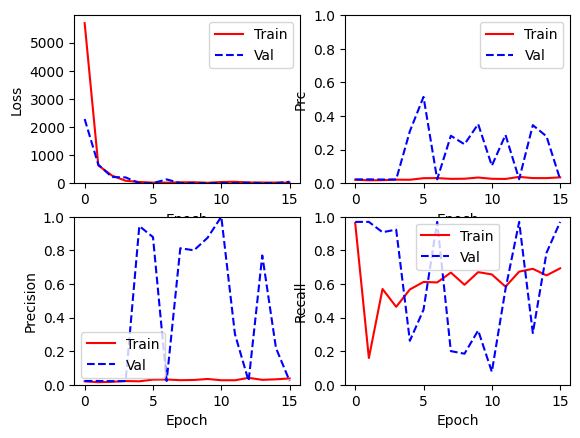

In [ ]:
plot_metrics(weighted_history)

loss :  0.15742217004299164
tp :  36.0
fp :  14.0
tn :  5732.0
fn :  33.0
accuracy :  0.9919174313545227
precision :  0.7200000286102295
recall :  0.52173912525177
auc :  0.7667489051818848
prc :  0.5082210302352905

Legitimate Transactions Detected (True Negatives):  5732
Legitimate Transactions Incorrectly Detected (False Positives):  14
Fraudulent Transactions Missed (False Negatives):  33
Fraudulent Transactions Detected (True Positives):  36
Total Fraudulent Transactions:  69


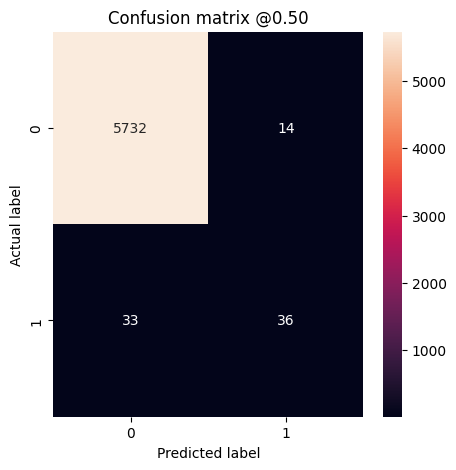

In [ ]:
baseline_results = weighted_model.evaluate(test_data_cnn, test_target_cnn[:, np.newaxis],
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()


train_predictions_weighted = weighted_model.predict(
    train_data, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(
    test_data_cnn, batch_size=BATCH_SIZE)
plot_cm(test_target_cnn[:, np.newaxis], test_predictions_weighted)


由於sklearn 的mplclassifier無法加入class weight，故以keras建立神經網絡，發現加入classweight後，結果大幅提升

#### 使用smote 增量

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote_train_data,smote_train_target = SMOTE().fit_resample(train_data,train_target)

 - 決策樹

Tree : Accuracy : 0.99,  Recall:0.76923, Precision : 0.50, F1_score : 0.60606
Tree : Accuracy : 0.99,  Recall:0.88971, Precision : 0.50, F1_score : 0.64021


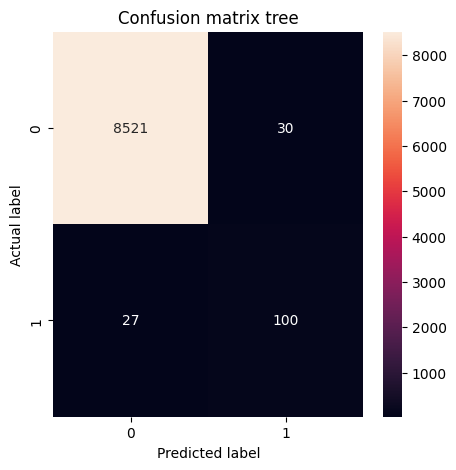

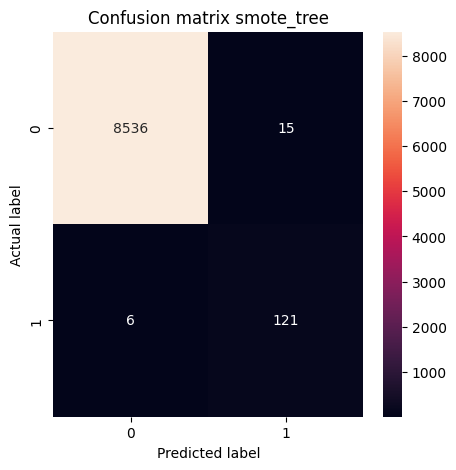

In [51]:

smote_tree = DecisionTreeClassifier(class_weight=class_weight)
smote_tree.fit(smote_train_data,smote_train_target)
smote_tree_pred = smote_tree.predict(test_data)

score_method(test_target,tree_pred,'tree')
score_method(test_target,smote_tree_pred,'smote_tree')

顯著提升

 - 神經網絡

Tree : Accuracy : 0.99,  Recall:0.87179, Precision : 0.50, F1_score : 0.63551
Tree : Accuracy : 0.99,  Recall:0.39785, Precision : 0.50, F1_score : 0.44311


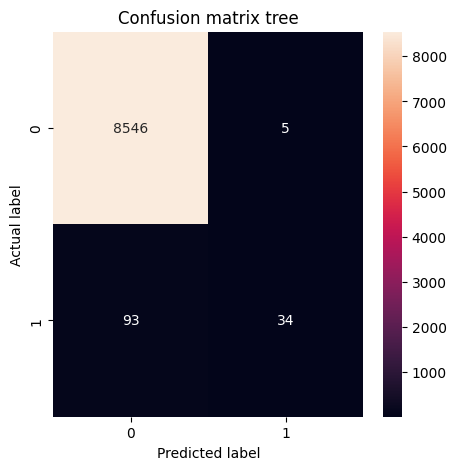

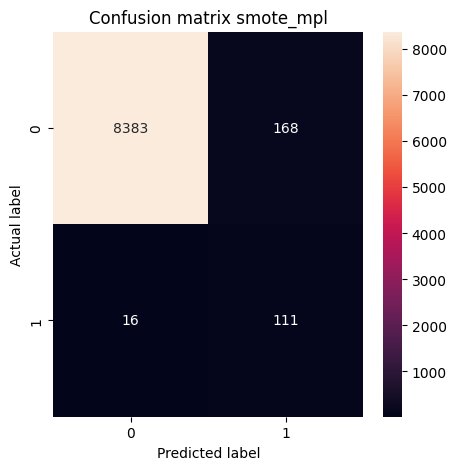

In [52]:
smote_mpl = MLPClassifier()
smote_mpl.fit(smote_train_data, smote_train_target)
smote_mpl_pred = smote_mpl.predict(test_data)

score_method(test_target,mpl_pred,'tree')
score_method(test_target,smote_mpl_pred,'smote_mpl')

顯著提升